CS7140

Rajesh Sakhamuru

Zhiyu Chen

# LSTM Model for mRNA Degredation Prediction with Attention Mechanism

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def oneHotEncode(rowDict):
    """
    One-hot encode a single sample's sequence data
    """
    categories = ['ACGU', '.()', 'BEHIMSX']

    seq = rowDict['sequence']
    oneHotSeq = np.zeros((len(seq),3))
    for i, char in enumerate(seq):
        oneHotSeq[i,0] = categories[0].index(char)

    struc = rowDict['structure']
    for i, char in enumerate(struc):
        oneHotSeq[i,1] = 4+categories[1].index(char)

    loop = rowDict['predicted_loop_type']
    for i, char in enumerate(loop):
        oneHotSeq[i,2] = 7+categories[2].index(char)

    return oneHotSeq

In [ ]:
def loadTrainData(filePath):
    """
    Loads training and target feature data from the test.json sequence data.
    One-hot encodes the data in the process.
    """
    oneHotTrain = None
    targetTrain = None
    with open(filePath, 'r') as data:
        for row in data:
            rowDict = json.loads(row)
            
            # Removes noisy training samples where SN_filter == 0 (Signal/Noise filter)
            if rowDict['SN_filter'] != 1:
                continue
            oneHotRow = oneHotEncode(rowDict)
            targets = np.stack([rowDict['reactivity'], rowDict['deg_Mg_pH10'],rowDict['deg_pH10'], rowDict['deg_Mg_50C'], rowDict['deg_50C']], axis=1)
            if oneHotTrain is None:
                oneHotTrain = np.array([oneHotRow])
                targetTrain = np.array([targets])
                continue

            oneHotTrain = np.append(oneHotTrain, [oneHotRow], axis=0)
            targetTrain = np.append(targetTrain, [targets], axis=0)

    return torch.tensor(oneHotTrain).to(torch.int64).to(device), torch.tensor(targetTrain).to(torch.float).to(device)

In [ ]:
def loadTestData(filePath):
    """
    Loads the 107 length and 130 length sequence data for seperate competition testing  
    One-hot encodes the data in the process.
    We do not have target values for this data
    """
    oneHotTest_107 = None
    oneHotTest_130 = None

    with open(filePath, 'r') as data:
        for row in data:
            rowDict = json.loads(row)
            oneHotRow = oneHotEncode(rowDict)

            if rowDict['seq_length'] == 107 and oneHotTest_107 is None:
                oneHotTest_107 = np.array([oneHotRow])
                continue
            elif rowDict['seq_length'] == 130 and oneHotTest_130 is None:
                oneHotTest_130 = np.array([oneHotRow])
                continue

            if rowDict['seq_length'] == 107:
                oneHotTest_107 = np.append(oneHotTest_107, [oneHotRow], axis=0)
            else:
                oneHotTest_130 = np.append(oneHotTest_130, [oneHotRow], axis=0)

    oneHotTest_107 = torch.tensor(oneHotTest_107).to(torch.int64).to(device)
    oneHotTest_130 = torch.tensor(oneHotTest_130).to(torch.int64).to(device)

    return oneHotTest_107, oneHotTest_130

In [ ]:
class ATT_LSTMBiDirecModel(nn.Module):
    """
    Bi-directional LSTM model which takes 14-features 1-hot encoded at each timestep
    with an attention layer for boosting long-term memory.
    """
    def __init__(self, seqLen=107, predLen=68, hidLayers=3, embedDim=300, hidDim=128):
        super(ATT_LSTMBiDirecModel, self).__init__()
        self.predLen=predLen
        self.embedding=nn.Embedding(14, embedDim)
        self.lstmLayers = nn.LSTM(input_size=embedDim*3,
                                  hidden_size=hidDim,
                                  num_layers=hidLayers,
                                  dropout=0.5,
                                  bidirectional=True,
                                  batch_first=True)
        self.attention = nn.Linear(seqLen,seqLen,bias=False)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(hidDim*2, 5)

    def forward(self,X):
        embedLayer = self.embedding(X)
        reshapedEmbedding = torch.reshape(embedLayer,(-1, embedLayer.shape[1], embedLayer.shape[2]*embedLayer.shape[3]))
        lstm_output, _ = self.lstmLayers(reshapedEmbedding)
        att_output = self.attention(lstm_output.transpose(1,2))
        att_output_drop = self.dropout(att_output)
        # Only make predictions for verifiable target values when training
        hiddenVals = att_output_drop.transpose(1,2)[:,:self.predLen,:]
        return self.linear(hiddenVals)

In [ ]:
class LSTMBiDirecModel(nn.Module):
    """
    Original Bi-directional LSTM model which takes 3-features with their 1-hot encoded column number at each timestep
    """
    def __init__(self, seqLen=107, predLen=68, hidLayers=3, embedDim=300, hidDim=128):
        super(LSTMBiDirecModel, self).__init__()
        self.predLen=predLen
        self.embedding=nn.Embedding(14, embedDim)
        self.lstmLayers = nn.LSTM(input_size=embedDim*3,
                                  hidden_size=hidDim,
                                  num_layers=hidLayers,
                                  dropout=0.5,
                                  bidirectional=True,
                                  batch_first=True)
        self.linear = nn.Linear(hidDim*2, 5)

    def forward(self,X):
        embedLayer = self.embedding(X)
        reshapedEmbedding = torch.reshape(embedLayer,(-1, embedLayer.shape[1], embedLayer.shape[2]*embedLayer.shape[3]))
        output, _ = self.lstmLayers(reshapedEmbedding)
        
        # Only make predictions for verifiable target values when training
        hiddenVals = output[:,:self.predLen,:]
        return self.linear(hiddenVals)

In [ ]:
def calcLoss(X, Y, model, optimizer=None, isTrain=True):
    """
    Calculate and backpropogate the loss based on the MSE loss function
    """
    model.train(isTrain)
    mseLoss = nn.MSELoss()
    predictions = model(X)
    loss = mseLoss(predictions, Y)
    if isTrain:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss.item()

4-fold cross validation for training LSTM model followed by validation

In [ ]:
def ATT_trainTestLSTMModel(oneHotTrain, targetTrain, test107DataLoader,test130DataLoader, lr=0.001, epochs=150, weightsPath='drive/MyDrive/Colab Notebooks/CS7140 Final Project/CS7140Models/att_covidLSTMModel.pth'):
    """
    Run 4-fold cross validation on the dataset to train it, then make a weighted average of the predictions and return the 
    predicitons and model history. Also plots training vs validation loss per epoch.
    """
    histories=[]
    test107Preds = np.zeros((oneHotTest_107.shape[0], 107, 5))
    test130Preds = np.zeros((oneHotTest_130.shape[0], 130, 5))

    # 4-fold validation and take the average predictions of the 4 folds for final submission
    kfold=KFold(n_splits=4, shuffle=True, random_state=42)
    for foldNum, (trainIdx, valIdx) in enumerate(kfold.split(oneHotTrain)):
        trainDataLoader = DataLoader(TensorDataset(oneHotTrain[trainIdx], targetTrain[trainIdx]), shuffle=True, batch_size=128)
        valDataLoader = DataLoader(TensorDataset(oneHotTrain[valIdx], targetTrain[valIdx]), shuffle=False, batch_size=128)
        
        att_lstmModel = ATT_LSTMBiDirecModel().to(device)
        optimizer = torch.optim.Adam(att_lstmModel.parameters(), lr=lr)
        
        trainLossList = []
        valLossList = []

        for epoch in range(epochs):
            trainLoss = []
            valLoss = []
            for X, Y in trainDataLoader:
                trainLoss.append(calcLoss(X,Y,att_lstmModel, optimizer=optimizer, isTrain=True))
            for X, Y in valDataLoader:
                valLoss.append(calcLoss(X,Y,att_lstmModel, optimizer=optimizer, isTrain=False))
            trainLossList.append(sum(trainLoss)/len(trainLoss))
            valLossList.append(sum(valLoss)/len(valLoss))
    
        att_lstmWeightsState = att_lstmModel.state_dict()
        del att_lstmModel

        histories.append({'trainLoss':trainLossList, 'valLoss': valLossList})
        
        if foldNum == 0:
            plt.plot(trainLossList,'b-',label='train')
            plt.plot(valLossList,'g-',label='val')
        else:
            plt.plot(trainLossList,'b-')
            plt.plot(valLossList,'g-')
        
        # load weights into model for length 107 sequences and make predictions
        att_lstmTest107Model = ATT_LSTMBiDirecModel(seqLen=107,predLen=107).to(device)
        att_lstmTest107Model.load_state_dict(att_lstmWeightsState)
        # turn off dropout during evaluation
        att_lstmTest107Model.eval()
        predictions107 = np.ndarray((0,107,5))
        for testData in test107DataLoader:
            testData = testData[0]
            pred107 = att_lstmTest107Model(testData)
            pred107 = pred107.cpu().detach().numpy()
            predictions107 = np.concatenate([predictions107, pred107], axis=0)
        test107Preds += predictions107/4
        
        # load weights into model for length 130 sequences and make predictions
        # weights from base LSTM model
        weights130Path = 'drive/MyDrive/Colab Notebooks/CS7140 Final Project/CS7140Models/130_covidLSTMModel.pth'
        lstmTest130Model = LSTMBiDirecModel(seqLen=130,predLen=130).to(device)
        lstmTest130Model.load_state_dict(torch.load(weights130Path))
        # turn off dropout during evaluation
        lstmTest130Model.eval()
        predictions130 = np.ndarray((0,130,5))
        for testData in test130DataLoader:
            testData = testData[0]
            pred130 = lstmTest130Model(testData)
            pred130 = pred130.cpu().detach().numpy()
            predictions130 = np.concatenate([predictions130, pred130], axis=0)
        test130Preds += predictions130/4

        print("Fold:",foldNum,", ValidationLoss:",valLossList[-1])

        del att_lstmTest107Model, lstmTest130Model      
    
    plt.legend(loc='best')
    plt.show()

    return test107Preds, test130Preds, histories

In [ ]:
dataFolder = "drive/MyDrive/Colab Notebooks/CS7140 Final Project/stanford-covid/"
testPath = dataFolder + "test.json"
trainPath = dataFolder + "train.json"

In [ ]:
oneHotTrain, targetTrain = loadTrainData(trainPath)

In [ ]:
# (samples, timesteps, features)
print('Input Shape: ', oneHotTrain.shape)
# Only the first 68 steps in the nucleotide sequence are scored in the training data
print('Output Shape:', targetTrain.shape)

Input Shape:  torch.Size([1589, 107, 3])
Output Shape: torch.Size([1589, 68, 5])


In [ ]:
oneHotTest_107, oneHotTest_130 = loadTestData(testPath)

test107DataLoader = DataLoader(TensorDataset(oneHotTest_107), shuffle=False, batch_size=128)
test130DataLoader = DataLoader(TensorDataset(oneHotTest_130), shuffle=False, batch_size=128)

Fold: 0 , ValidationLoss: 0.07343992777168751
Fold: 1 , ValidationLoss: 0.07368341460824013
Fold: 2 , ValidationLoss: 0.06638895347714424
Fold: 3 , ValidationLoss: 0.06717887707054615


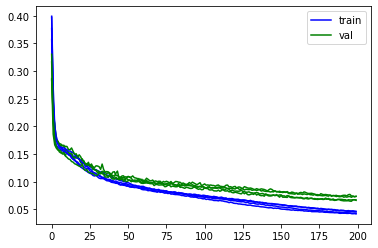

In [ ]:
test107Preds, test130Preds, histories = ATT_trainTestLSTMModel(oneHotTrain, targetTrain, test107DataLoader, test130DataLoader, lr=0.0008, epochs=200)

In [ ]:
# print settings for pandas dataframes
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('expand_frame_repr', False)

sampleSubmPath = dataFolder + "sample_submission.csv"
submissionDF = pd.read_csv(sampleSubmPath, index_col='id_seqpos')

with open(testPath, 'r') as testdata:
    idx107 = 0
    idx130 = 0
    i = 0
    for row in testdata:
        rowDict = json.loads(row)
        if rowDict['seq_length'] == 107:
            for x in range(107):
                submissionDF.iloc[i] = {'reactivity': test107Preds[idx107][x][0],
                                        'deg_Mg_pH10': test107Preds[idx107][x][1],
                                        'deg_pH10': test107Preds[idx107][x][2],
                                        'deg_Mg_50C': test107Preds[idx107][x][3],
                                        'deg_50C':test107Preds[idx107][x][4]}
                i += 1
            idx107 += 1
        elif rowDict['seq_length'] == 130:
            for x in range(130):
                submissionDF.iloc[i] = {'reactivity': test130Preds[idx130][x][0],
                                        'deg_Mg_pH10': test130Preds[idx130][x][1],
                                        'deg_pH10': test130Preds[idx130][x][2],
                                        'deg_Mg_50C': test130Preds[idx130][x][3],
                                        'deg_50C':test130Preds[idx130][x][4]}
                i += 1
            idx130 += 1
        
print(submissionDF)

                  reactivity  deg_Mg_pH10  deg_pH10  deg_Mg_50C   deg_50C
id_seqpos                                                                
id_00073f8be_0      0.609807     0.677789  1.978338    0.548310  0.689297
id_00073f8be_1      1.974702     2.825746  3.951524    2.843962  2.481364
id_00073f8be_2      1.247643     0.962429  1.076436    1.152148  1.121656
id_00073f8be_3      1.056678     0.855254  1.051009    1.182603  1.121098
id_00073f8be_4      0.926530     0.905938  1.098576    1.254745  1.182959
...                      ...          ...       ...         ...       ...
id_ffda94f24_125    0.261841     0.437706  0.564426    0.655878  0.423200
id_ffda94f24_126    0.240583     0.430785  0.723411    0.683263  0.609998
id_ffda94f24_127    0.553731     0.118046  0.269278    0.278089  0.356205
id_ffda94f24_128    0.220393     0.113388  0.209500    0.271384  0.160627
id_ffda94f24_129    0.044604     0.095944  0.376354    0.314239  0.201165

[457953 rows x 5 columns]


In [ ]:
submissionDF.to_csv(dataFolder+'ATT_LSTMSubmission.csv')

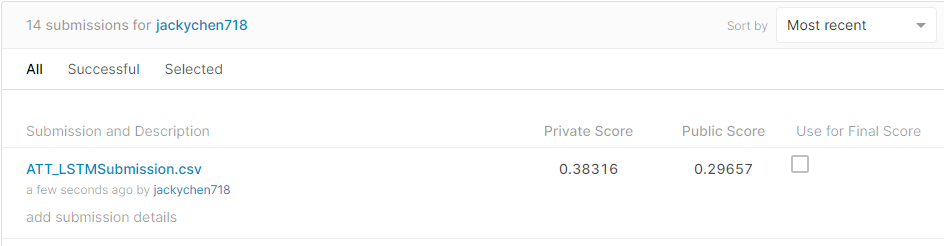

Even thought the model is better than CNN, it is still not very competitive. First, the model uses LSTM on the sequence. Then, use a Linear layer to predict the result. For the squence length of 107 public records, we also tried an attention layer to learn the influence between different time steps. 

In reality, it appears that adding the attention mechanism actually worsened the model output. We can determine that adding an attention mechanism to the LSTM model given this specific data does not improve the performance of the predictions in any way and seems to just introduce some noise to the data. One other drawback of the model is that the method cannot be used to predict the 130 nucleotide sequence as the attention mechanism weights cannot be translated to a longer sequence which would need a different size layer. 

